In [1]:
"""
Created on October 14 2018
@author: Neven Caplar
@contact: ncaplar@princeton.edu
"""
"""
Edited and remade on June 17th, 2019
@author: Theodore Pena
@contact: theodore.pena@tufts.edu
"""
print()

We'll start everything off with some basic imports.

In [2]:
import sys
print("sys version: {}".format(sys.version))
# This project is entirely in python 3.7

import matplotlib
import matplotlib.pyplot as plt
%matplotlib qt 
# If you don't have an X server, line 7 might crash your kernel. Try '%matplotlib inline' instead.

import numpy as np
print("numpy version: {}".format(np.__version__))

import pandas as pd
print("pandas version: {}".format(pd.__version__))

from tqdm import tqdm
# This gives for loops progress bars.

from sklearn.metrics.pairwise import euclidean_distances
# We need this to match AGN from one catalog to another.

from IPython.core.display import display, HTML
# An alternate, cleaner take on the jupyter workspace
display(HTML("<style>.container { width:100% !important; }</style>"))

sys version: 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
numpy version: 1.16.2
pandas version: 0.24.2


The below cell is just code prettification. Feel free to skip if you dislike any changes.

In [4]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

Last thing we've got left is to define a few global variables we're going to come back to.

In [5]:
DATA_DIRECTORY='/home/tpena01/AGN_variability_project/Data/'
# Change '/home/tpena01' to a path leading to my variability repo, presuming you've alredy cloned it.
# If not, here's a link: https://github.com/openhearted99/AGN_variability_project

HSC_CATALOG_NAME = 'HSCpdr2QuasarCatalog.csv'
# If you're pulling data from your own HSC catalog, put your new catalog in
# .../AGN_variability_project, and change this.

# Data intake

## SDSS

The first catalog we'll need is the SDSS quasar catalog, DR7 edition. Read about it here: https://classic.sdss.org/dr7/products/value_added/qsocat_dr7.html.

In [6]:
dr7 = pd.read_csv(DATA_DIRECTORY+'SDSSdr7QuasarCatalog.dat', skiprows=80, sep='\s+', engine='python', error_bad_lines=False, header=None)

Skipping line 305: Expected 75 fields in line 305, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 1633: Expected 75 fields in line 1633, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 1745: Expected 75 fields in line 1745, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 1828: Expected 75 fields in line 1828, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 3631: Expected 75 fields in line 3631, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 4123: Expected 75 fields in line 4123, saw 76. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.
Skipping line 4124: Expected 75 fields in line 4124, saw 76. Error could possibly be due to quotes bei

Before we extract our list of positions, let's clean the catalog a bit. Here we're selecting all quasars with 'target_selection_flag(TARGET)' equal to one.

In [7]:
_len_before = dr7.shape[0]

dr7 = dr7[dr7.iloc[:,54] == 1]

_len_after = dr7.shape[0]

print("Number of objects lost = " + str(_len_before - _len_after))

Number of objects lost = 37280


In [9]:
Positions_of_dr7 = np.transpose([dr7[1].values, dr7[2].values])

## HSC

The next step of our analysis requires Hyper Subprime Camera data for the SDSS quasars, which we get from https://hsc-release.mtk.nao.ac.jp. If you'd like to download HSC data for yourself, sign up for access here: https://hsc-release.mtk.nao.ac.jp/doc/index.php/tools-2/

HSC data is obtained through an SQL query. The next few cells are devoted to setting up said query.

In [10]:
data = np.zeros(len(Positions_of_dr7), dtype={'names':('ra', 'dec'),
                          'formats':('f8','f8')})

data['ra'] = Positions_of_dr7[:,0]
data['dec'] =  Positions_of_dr7[:,1]

PositionOfQuasars = data

# Store the positions for later reference
np.save(DATA_DIRECTORY + 'PositionOfQuasars', PositionOfQuasars)
PositionOfQuasa = np.load(DATA_DIRECTORY + 'PositionOfQuasars.npy')

Each string below represents an attribute of a source that we're searching for.

In [11]:
column_names=["f.ra","f.dec","f.g_cmodel_mag","f.g_cmodel_magsigma","f.r_cmodel_mag","f.r_cmodel_magsigma","f.i_cmodel_mag","f.i_cmodel_magsigma","f2.g_psfflux_mag","f2.g_psfflux_magsigma","f2.r_psfflux_mag",
              "f2.r_psfflux_magsigma","f2.i_psfflux_mag","f2.i_psfflux_magsigma","f.object_id","f2.g_psfflux_flag","f2.r_psfflux_flag","f2.i_psfflux_flag","f.g_cmodel_flag","f.r_cmodel_flag","f.i_cmodel_flag",
              "f.g_pixelflags_edge","f.r_pixelflags_edge","f.i_pixelflags_edge","f.g_pixelflags_bad","f.r_pixelflags_bad","f.i_pixelflags_bad","f.g_pixelflags_interpolatedcenter",
              "f.r_pixelflags_interpolatedcenter","f.i_pixelflags_interpolatedcenter","f.g_pixelflags_saturatedcenter","f.r_pixelflags_saturatedcenter","f.i_pixelflags_saturatedcenter",
              "f.g_pixelflags_crcenter","f.r_pixelflags_crcenter","f.i_pixelflags_crcenter"]

Head on over to .../AGN_variability_project/Data, and run the following command at your terminal. (You can just copy and paste the output from the next cell).

In [12]:
print('python QueryGenerator.py PositionOfQuasars.npy --columns ['  "\""+"\",\"".join(column_names)+"\""+']')

python QueryGenerator.py PositionOfQuasars.npy --columns ["f.ra","f.dec","f.g_cmodel_mag","f.g_cmodel_magsigma","f.r_cmodel_mag","f.r_cmodel_magsigma","f.i_cmodel_mag","f.i_cmodel_magsigma","f2.g_psfflux_mag","f2.g_psfflux_magsigma","f2.r_psfflux_mag","f2.r_psfflux_magsigma","f2.i_psfflux_mag","f2.i_psfflux_magsigma","f.object_id","f2.g_psfflux_flag","f2.r_psfflux_flag","f2.i_psfflux_flag","f.g_cmodel_flag","f.r_cmodel_flag","f.i_cmodel_flag","f.g_pixelflags_edge","f.r_pixelflags_edge","f.i_pixelflags_edge","f.g_pixelflags_bad","f.r_pixelflags_bad","f.i_pixelflags_bad","f.g_pixelflags_interpolatedcenter","f.r_pixelflags_interpolatedcenter","f.i_pixelflags_interpolatedcenter","f.g_pixelflags_saturatedcenter","f.r_pixelflags_saturatedcenter","f.i_pixelflags_saturatedcenter","f.g_pixelflags_crcenter","f.r_pixelflags_crcenter","f.i_pixelflags_crcenter"]


Then, copy and pastte the output into the SQL entry box of the CAS search page (find this on the HSC's website). Don't be discouraged if the estimated completion time seems absurd; we once had a query time estimate of 12 days and the run took 58 minutes. This is a known bug.

You don't need to find your own data, however. If you'd just like to use the HSC catalog we generated, continue to follow along.

In [13]:
df = pd.read_csv(DATA_DIRECTORY + HSC_CATALOG_NAME)

In [14]:
Positions_of_df = np.transpose([df['# ra'].values, df['dec'].values])

# Analysis of the output

## Initial Analysis

Let's start our analysis in earnest. First, we'll check the overlap of the HSC data with SDSS.

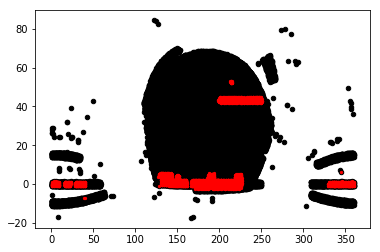

In [15]:
plt.scatter(Positions_of_dr7[:, 0], Positions_of_dr7[:, 1], color='black', s=20)
plt.scatter(Positions_of_df[:, 0], Positions_of_df[:, 1], color='red', s=5)
plt.show()

Now that we have some spatial sense of our quasars, let's try to match objects from one catalog to objects in the other catalog. The next three cells should take around a minute to run.

In [16]:
res_matching = []
for j in tqdm(range(len(Positions_of_dr7))):
    
    # Find the distance between each object in the dr7 catalog and each object in the HSC catalog
    PositionOfQuasars_euclidean_distances = euclidean_distances([Positions_of_dr7[j]], Positions_of_df)
    
    # Find the shortest distance
    shortest_distance = np.min(PositionOfQuasars_euclidean_distances[0])
    
    # Match the elements
    shortest_distance_index=np.where(PositionOfQuasars_euclidean_distances[0] == np.min(PositionOfQuasars_euclidean_distances[0]))[0][0]
    res_matching.append([shortest_distance, df.loc[shortest_distance_index].values])

100%|██████████| 68365/68365 [01:01<00:00, 1118.43it/s]


In [24]:
# create array that has objects from SDSS that are found in HSC
matched_array = []
matched_array_extended_SDSS = []
for i in tqdm(range(len(res_matching))):
    
    if res_matching[i][0] > 0.001:
        pass
    
    else:
        # extract columns 0,1,2,3,6,7,8,9,10,11 from SDSS, which are SDSS ID, ra, dec, redshift and psf measurments in different bands (g->[6,7],r->[8,9],i->[10,11])
        matched_array.append(np.concatenate((dr7.iloc[i][[0, 1, 2, 3, 6, 7, 8, 9, 10, 11]], res_matching[i][1])))
        
        # extract columns 1,2,3 which are ra, dec and redshift (plan to add mass from Schen catalog)
        matched_array_extended_SDSS.append(np.concatenate((dr7.iloc[i][[1, 2, 3]], res_matching[i][1])))
        
matched_array = np.array(matched_array)
matched_array_extended_SDSS = np.array(matched_array_extended_SDSS)

100%|██████████| 68365/68365 [00:16<00:00, 4118.12it/s]


In [26]:
# filter out QSO which failed measurment, (g-band set at 0 in SDSS catlog)
matched_array = matched_array[matched_array[:, 4] > 16]
#matched_array_extended_SDSS = matched_array_extended_SDSS[matched_array[:, 4] > 16]

# Combining both c-model and psf magnitudes and output

In [27]:
def extract_data(matched_array, SDSSband=4, HSCband=18, info=1):
    """
    info just determines if you want a return value of (delta_band, redshift), or
    (delta_band, redshift, g_mag_SDSS)
    """
    # Set variables
    redshift_col = 3
    SDSSerr = SDSSband + 1
    HSCerr = HSCband + 1
    g_mag_SDSS_col = 4
    g_mag_HSC_col = 18
    
    matched_array_filtered = matched_array[np.isfinite(matched_array[:, SDSSband].astype(float)) & \
                                           np.isfinite(matched_array[:, HSCband].astype(float)) & \
                                           np.isfinite(matched_array[:, SDSSerr].astype(float)) & \
                                           np.isfinite(matched_array[:, HSCerr].astype(float))]
    
    band_mag_dif = (matched_array_filtered[:, SDSSband] - matched_array_filtered[:, HSCband]).astype(float)
    
    
    band_mag_dif_err = np.sqrt(((matched_array_filtered[:, SDSSerr]).astype(float))**2 +
                               ((matched_array_filtered[:, HSCerr]).astype(float))**2)
    if info == 1:
        band_mag_dif = np.vstack((band_mag_dif, matched_array_filtered[:, redshift_col]))
        
    if info== 2:
        band_mag_dif = np.vstack((band_mag_dif, matched_array_filtered[:, redshift_col]))
        band_mag_dif = np.vstack((band_mag_dif, matched_array_filtered[:, g_mag_SDSS_col]))
        
    if info== 3:
        band_mag_dif = np.vstack((band_mag_dif, matched_array_filtered[:, redshift_col]))
        band_mag_dif = np.vstack((band_mag_dif, matched_array_filtered[:, g_mag_HSC_col]))
    
    return (band_mag_dif.T, band_mag_dif_err)

In [28]:
# sdss psf-g band mag - HSC psf-g band mag, with error
g_mag_dif_and_redshift, g_mag_err = extract_data(matched_array, SDSSband=4, HSCband=18)

# sdss psf-r band mag - HSC psf-r band mag, with error
r_mag_dif_and_redshift, r_mag_err = extract_data(matched_array, SDSSband=6, HSCband=20)

# sdss psf-i band mag - HSC psf-i band, with error
i_mag_dif_and_redshift, i_mag_err = extract_data(matched_array, SDSSband=8, HSCband=22)


# sdss psf-g band mag - HSC cmodel-g band mag, with error
gcmodel_mag_dif_and_redshift, gcmodel_mag_err = extract_data(matched_array, SDSSband=4, HSCband=12)

# sdss psf-r band mag - HSC cmodel-r band mag, with error
rcmodel_mag_dif_and_redshift, rcmodel_mag_err = extract_data(matched_array, SDSSband=6, HSCband=14)

# sdss psf-i band mag - HSC cmodel-i band, with error
icmodel_mag_dif_and_redshift, icmodel_mag_err = extract_data(matched_array, SDSSband=8, HSCband=18)

# Small investigation of the properties of sources selected as variable

## Graphing function

In [54]:
def make_graph(data_array, SDSSband=4, HSCband=18, obj_per_bin=100, sortby='redshift', smoothing_method='mean', num_to_choose=None, ylim=None, xlim=None):
    '''
    Graphing function. 
    Input is matched_array and your favorite set of parameters.
    Output is a graph.
    '''
    
    # Failsafe in case the user forgets to select a number of objects per bin.
    if (num_to_choose == None):
        num_to_choose = obj_per_bin
        
    
    if (sortby == 'delta_band'):
        
        # Extract the data that we're going to use.
        delta_band_and_redshift, delta_band_err = extract_data(data_array, SDSSband, HSCband, info=1)    
        
        # Split our data into bins. Each bin has "obj_per_bin" elements
        delta_band_and_redshift_sorted_and_split=np.array_split(delta_band_and_redshift[np.argsort(delta_band_and_redshift[:,0])], int(len(delta_band_and_redshift)/obj_per_bin))
        
        # The following pair of for loops sorts and smooths the data.
        res_delta_band_and_redshift = []
        res_delta_band_and_redshift_median = []
        res_delta_std = []
        
        for i in range(len(delta_band_and_redshift_sorted_and_split)):
            res_delta_band_and_redshift.append(np.mean(delta_band_and_redshift_sorted_and_split[i],axis=0))
            res_delta_band_and_redshift_median.append(np.median(delta_band_and_redshift_sorted_and_split[i],axis=0))
            res_delta_std.append(np.array(delta_band_and_redshift_sorted_and_split[i][:,:], dtype=np.float64).std(axis=0))

        # Now that our data is in a graph
        res_delta_band_and_redshift=np.array(res_delta_band_and_redshift)
        res_delta_band_and_redshift_median=np.array(res_delta_band_and_redshift_median)
        res_delta_std=np.array(res_delta_std)

        
        if (smoothing_method == 'mean'):
            # Plotting
            matplotlib.rcParams.update({'font.size': 12})
            plt.figure(figsize=(18,6))
            plt.title('negative $\Delta$ BAND-band values= fainter in HSC; positive $\Delta$ BAND-band values= brighter in HSC; DATA ORIGIN UNKNOWN')
            plt.errorbar(res_delta_band_and_redshift[:,0], res_delta_band_and_redshift[:,1], yerr=res_delta_std[:,1])   
            plt.xlabel('$\Delta$ BAND-band (SDSS - HSC)')
            plt.ylabel('redshift')
            if (ylim != None):
                plt.ylim(ylim[0], ylim[1])
            if (xlim != None):
                plt.xlim(xlim[0], xlim[1])
                
            plt.show()
        
        elif (smoothing_method == 'median'):
            # Plotting
            matplotlib.rcParams.update({'font.size': 12})
            plt.figure(figsize=(18,6))
            plt.title('negative $\Delta$ BAND-band values= fainter in HSC; positive $\Delta$ BAND-band values= brighter in HSC; DATA ORIGIN UNKNOWN')
            plt.errorbar(res_delta_band_and_redshift_median[:,0], res_delta_band_and_redshift_median[:,1], yerr=res_delta_std[:,1])
            plt.xlabel('$\Delta$ g-band (SDSS - HSC)')
            plt.ylabel('redshift')
            if (ylim != None):
                plt.ylim(ylim[0], ylim[1])
            if (xlim != None):
                plt.xlim(xlim[0], xlim[1])
            
            plt.show()
            
        else:
            # Throw an error here later
            pass
    
    
    elif (sortby == 'redshift'):
      
        # Extract the data that we're going to use.
        delta_band_and_redshift, delta_band_err = extract_data(data_array, SDSSband, HSCband, info=1)
    
    
        delta_band_and_redshift_sorted_and_split=np.array_split(delta_band_and_redshift[np.argsort(delta_band_and_redshift[:,1])], int(len(delta_band_and_redshift)/obj_per_bin))

        # Smoothing
        res_delta_band_and_redshift = []
        res_delta_band_and_redshift_median = []
        res_delta_std = []
        

        for i in range(len(delta_band_and_redshift_sorted_and_split)):
            res_delta_band_and_redshift.append(np.mean(delta_band_and_redshift_sorted_and_split[i],axis=0))
            res_delta_band_and_redshift_median.append(np.median(delta_band_and_redshift_sorted_and_split[i],axis=0))
            res_delta_std.append(np.array(delta_band_and_redshift_sorted_and_split[i][:,:], dtype=np.float64).std(axis=0))
                
        res_delta_band_and_redshift=np.array(res_delta_band_and_redshift)
        res_delta_band_and_redshift_median=np.array(res_delta_band_and_redshift_median)
        res_delta_std=np.array(res_delta_std)

                
        second_deg_fit=np.poly1d(np.polyfit(res_delta_band_and_redshift[:,1].astype(float), res_delta_band_and_redshift[:,0].astype(float), 2))
    
        
        if (smoothing_method == 'mean'):
            # PLotting
            matplotlib.rcParams.update({'font.size': 12})
            plt.figure(figsize=(18,6))
            plt.title('negative $\Delta$ BAND-band values= fainter in HSC; positive $\Delta$ BAND-band values= brighter in HSC; DATA ORIGIN UNKNOWN')
            plt.errorbar(res_delta_band_and_redshift[:,1], res_delta_band_and_redshift[:,0], yerr=res_delta_std[:,0])
            plt.plot(res_delta_band_and_redshift[:,1], second_deg_fit(res_delta_band_and_redshift[:,1].astype(float)), ls='--', color='orange')    
            plt.ylabel('$\Delta$ BAND-band (SDSS - HSC)')
            plt.xlabel('redshift')
            if (ylim != None):
                plt.ylim(ylim[0], ylim[1])
            if (xlim != None):
                plt.xlim(xlim[0], xlim[1])
                
            plt.show()
        
        elif (smoothing_method == 'median'):
            # PLotting
            matplotlib.rcParams.update({'font.size': 12})
            plt.figure(figsize=(18,6))
            plt.title('negative $\Delta$ BAND-band values= fainter in HSC; positive $\Delta$ BAND-band values= brighter in HSC; DATA ORIGIN UNKNOWN')
            plt.errorbar(res_delta_band_and_redshift_median[:,1], res_delta_band_and_redshift_median[:,0], yerr=res_delta_std[:,0])
            plt.plot(res_delta_band_and_redshift_median[:,1], second_deg_fit(res_delta_band_and_redshift_median[:,1].astype(float)), ls='--', color='orange')    
            plt.ylabel('$\Delta$ BAND-band (SDSS - HSC)')
            plt.xlabel('redshift')
            if (ylim != None):
                plt.ylim(ylim[0], ylim[1])
            if (xlim != None):
                plt.xlim(xlim[0], xlim[1])
                
            plt.show()
    

    elif (sortby == 'g_mag_SDSS'):
        
        # Extract the data that we're going to use.
        delta_band_and_redshift, delta_band_err = extract_data(data_array, SDSSband, HSCband, info=2)
        
        
        delta_band_and_redshift_sorted_and_split=np.array_split(delta_band_and_redshift[np.argsort(delta_band_and_redshift[:,1])], int(len(delta_band_and_redshift)/obj_per_bin))
        
        
        
        # Next we sort each bin by g_mag
        for i in range(len(delta_band_and_redshift_sorted_and_split)):
            delta_band_and_redshift_sorted_and_split[i] = delta_band_and_redshift_sorted_and_split[i][np.argsort(delta_band_and_redshift_sorted_and_split[i][:, delta_band_and_redshift_sorted_and_split[i].shape[1]-1])]

            

        res_delta_band_and_redshift = []
        res_delta_band_and_redshift_median = []
        res_delta_std = []
        
        if (num_to_choose < 0):
            for i in range(len(delta_band_and_redshift_sorted_and_split)):
                res_delta_band_and_redshift.append(np.mean(delta_band_and_redshift_sorted_and_split[i][num_to_choose:],axis=0))
                res_delta_std.append(np.array(delta_band_and_redshift_sorted_and_split[i][num_to_choose:][:,:], dtype=np.float64).std(axis=0))
                res_delta_band_and_redshift_median.append(np.median(delta_band_and_redshift_sorted_and_split[i][num_to_choose:],axis=0))

        elif (num_to_choose >= 0):
            for i in range(len(delta_band_and_redshift_sorted_and_split)):
                res_delta_band_and_redshift.append(np.mean(delta_band_and_redshift_sorted_and_split[i][:num_to_choose],axis=0))
                res_delta_band_and_redshift_median.append(np.median(delta_band_and_redshift_sorted_and_split[i][:num_to_choose],axis=0))
                res_delta_std.append(np.array(delta_band_and_redshift_sorted_and_split[i][:num_to_choose][:,:], dtype=np.float64).std(axis=0))

        else:
            # You guessed it, throw an error
            pass
        
        res_delta_band_and_redshift=np.array(res_delta_band_and_redshift)
        res_delta_band_and_redshift_median=np.array(res_delta_band_and_redshift_median)
        res_delta_std=np.array(res_delta_std)
        

                
        second_deg_fit=np.poly1d(np.polyfit(res_delta_band_and_redshift[:,1].astype(float), res_delta_band_and_redshift[:,0].astype(float), 2))
    
        
        if (smoothing_method == 'mean'):
            # PLotting
            matplotlib.rcParams.update({'font.size': 12})
            plt.figure(figsize=(18,6))
            plt.title('negative $\Delta$ BAND-band values= fainter in HSC; positive $\Delta$ BAND-band values= brighter in HSC; DATA ORIGIN UNKNOWN')
            plt.errorbar(res_delta_band_and_redshift[:,1], res_delta_band_and_redshift[:,0], yerr=res_delta_std[:,0])
            plt.plot(res_delta_band_and_redshift[:,1], second_deg_fit(res_delta_band_and_redshift[:,1].astype(float)), ls='--', color='orange')    
            plt.ylabel('$\Delta$ BAND-band (SDSS - HSC)')
            plt.xlabel('redshift')
            if (ylim != None):
                plt.ylim(ylim[0], ylim[1])
            if (xlim != None):
                plt.xlim(xlim[0], xlim[1])
                
            plt.show()
        
        elif (smoothing_method == 'median'):
            # PLotting
            matplotlib.rcParams.update({'font.size': 12})
            plt.figure(figsize=(18,6))
            plt.title('negative $\Delta$ BAND-band values= fainter in HSC; positive $\Delta$ BAND-band values= brighter in HSC; DATA ORIGIN UNKNOWN')
            plt.errorbar(res_delta_band_and_redshift_median[:,1], res_delta_band_and_redshift_median[:,0], yerr=res_delta_std[:,0])
            plt.plot(res_delta_band_and_redshift_median[:,1], second_deg_fit(res_delta_band_and_redshift_median[:,1].astype(float)), ls='--', color='orange')    
            plt.ylabel('$\Delta$ BAND-band (SDSS - HSC)')
            plt.xlabel('redshift')
            if (ylim != None):
                plt.ylim(ylim[0], ylim[1])
            if (xlim != None):
                plt.xlim(xlim[0], xlim[1])
                
            plt.show()
            

    elif (sortby == 'g_mag_HSC'):
        
        # Extract the data that we're going to use.
        delta_band_and_redshift, delta_band_err = extract_data(data_array, SDSSband, HSCband, info=3)
        print(delta_band_redshift.shape)
    
        
        delta_band_and_redshift_sorted_and_split=np.array_split(delta_band_and_redshift[np.argsort(delta_band_and_redshift[:,1])], int(len(delta_band_and_redshift)/obj_per_bin))
        
        
        
        # Next we sort each bin by g_mag
        for i in range(len(delta_band_and_redshift_sorted_and_split)):
            delta_band_and_redshift_sorted_and_split[i] = delta_band_and_redshift_sorted_and_split[i][np.argsort(delta_band_and_redshift_sorted_and_split[i][:, delta_band_and_redshift_sorted_and_split[i].shape[1]-1])]

        res_delta_band_and_redshift = []
        res_delta_band_and_redshift_median = []
        res_delta_std = []
        
        if (num_to_choose <= 0):
            for i in range(len(delta_band_and_redshift_sorted_and_split)):
                res_delta_band_and_redshift.append(np.mean(delta_band_and_redshift_sorted_and_split[i][num_to_choose:],axis=0))
                res_delta_band_and_redshift_median.append(np.median(delta_band_and_redshift_sorted_and_split[i][num_to_choose:],axis=0))
                res_delta_std.append(np.array(delta_band_and_redshift_sorted_and_split[i][num_to_choose:][:,:], dtype=np.float64).std(axis=0))

        elif (num_to_choose >= 0):
            for i in range(len(delta_band_and_redshift_sorted_and_split)):
                res_delta_band_and_redshift.append(np.mean(delta_band_and_redshift_sorted_and_split[i][:num_to_choose],axis=0))
                res_delta_band_and_redshift_median.append(np.median(delta_band_and_redshift_sorted_and_split[i][:num_to_choose],axis=0))
                res_delta_std.append(np.array(delta_band_and_redshift_sorted_and_split[i][:num_to_choose][:,:], dtype=np.float64).std(axis=0))

        else:
            # You guessed it, throw an error
            pass
        
        res_delta_band_and_redshift=np.array(res_delta_band_and_redshift)
        res_delta_band_and_redshift_median=np.array(res_delta_band_and_redshift_median)
        res_delta_std=np.array(res_delta_std)
        

                
        second_deg_fit=np.poly1d(np.polyfit(res_delta_band_and_redshift[:,1].astype(float), res_delta_band_and_redshift[:,0].astype(float), 2))
    
        
        if (smoothing_method == 'mean'):
            # PLotting
            matplotlib.rcParams.update({'font.size': 12})
            plt.figure(figsize=(18,6))
            plt.title('negative $\Delta$ BAND-band values= fainter in HSC; positive $\Delta$ BAND-band values= brighter in HSC; DATA ORIGIN UNKNOWN')
            plt.errorbar(res_delta_band_and_redshift[:,1], res_delta_band_and_redshift[:,0], yerr=res_delta_std[:,0])
            plt.plot(res_delta_band_and_redshift[:,1], second_deg_fit(res_delta_band_and_redshift[:,1].astype(float)), ls='--', color='orange')    
            plt.ylabel('$\Delta$ BAND-band (SDSS - HSC)')
            plt.xlabel('redshift')
            if (ylim != None):
                plt.ylim(ylim[0], ylim[1])
            if (xlim != None):
                plt.xlim(xlim[0], xlim[1])
                
            plt.show()
        
        elif (smoothing_method == 'median'):
            # PLotting
            matplotlib.rcParams.update({'font.size': 12})
            plt.figure(figsize=(18,6))
            plt.title('negative $\Delta$ BAND-band values= fainter in HSC; positive $\Delta$ BAND-band values= brighter in HSC; DATA ORIGIN UNKNOWN')
            plt.errorbar(res_delta_band_and_redshift_median[:,1], res_delta_band_and_redshift_median[:,0], yerr=res_delta_std[:,0])
            plt.plot(res_delta_band_and_redshift_median[:,1], second_deg_fit(res_delta_band_and_redshift_median[:,1].astype(float)), ls='--', color='orange')    
            plt.ylabel('$\Delta$ BAND-band (SDSS - HSC)')
            plt.xlabel('redshift')
            if (ylim != None):
                plt.ylim(ylim[0], ylim[1])
            if (xlim != None):
                plt.xlim(xlim[0], xlim[1])
                
            plt.show()
    
    
    else:
        "Throw an error here later"
        pass

    return  

In [59]:
"""
DRIVER CELL
===============
data_col needs to be updated for the function to work properly!!
delta_g = 4
delta_g_cmodel=6
delta_r = 10
delta_r_cmodel = 12
delta_ i = 16
delta_i_cmodel = 18


PARAMETERS
---------------
data_array. Where you want to pull information from. 
data_col. Which column the data is in.
obj_per_bin. Self explaintory.
sortby. Options are 'redshift', 'delta_band', 'g_mag_HSC', and 'g_mag_SDSS' 
smoothing_method. Options are 'mean' and 'median'
num_to_choose=20. How many objects you want to choose to use from each bin. Only relevant when sorting due to g_band mag. Use a positive number to choose dim objects, negative to choose bright objects.
"""

make_graph(matched_array, SDSSband=4, HSCband=18, obj_per_bin=100, sortby='redshift', smoothing_method='mean', num_to_choose=20, ylim=(-0.4, 0.2), xlim=(.1, .3))
#make_graph(matched_array, data_col=18, obj_per_bin = 100, sortby='g_mag_SDSS', smoothing_method='mean', num_to_choose=20, ylim=(-0.4, 0.2), xlim=(.1, .3))

## Further plots

In [ ]:
np.std(np.array(x[9][:,0]))
graphable_data = []
for i in range(len(x[9])):
    graphable_data.append(x[9][i,0])

In [ ]:
plt.hist(graphable_data)
plt.axvline(np.mean(graphable_data), color='red')
plt.hist(graphable_data[-20:])
plt.axvline(np.mean(graphable_data[-20:]), color='cyan')
plt.hist(graphable_data[:20])
plt.axvline(np.mean(graphable_data[:20]), color='black')
plt.show()

## Custom order plot

In [176]:
def DCSP(data_col=4, smoothing_method='mean', ylim=None, num_to_choose=None):
    '''
    Graphing function. 
    Input is new_matched_data_array and your favorite set of parameters.
    Output is a graph.
    '''
    # Set variables
    redshift_col = 3
    error_col = data_col + 1
    g_mag_SDSS_col = 8
    obj_per_bin = 100
    data_array = matched_data_array
    
    # Failsafe in case the user forgets to select a number of objects per bin.
    
    # Extract the data that we're going to use.
    delta_band_and_redshift = data_array[:, [data_col, redshift_col]]
    
    # Add on a row that represents the g_mag in SDSS. We'll sort by this later
    delta_band_and_redshift = np.hstack((delta_band_and_redshift, np.reshape(data_array[:, g_mag_SDSS_col], (len(data_array[:]),1)) ))


    delta_band_and_redshift_sorted_and_split=np.array_split(delta_band_and_redshift[np.argsort(delta_band_and_redshift[:,1])], int(len(delta_band_and_redshift)/obj_per_bin))



    # Next we sort each bin by g_mag
    for i in range(len(delta_band_and_redshift_sorted_and_split)):
        delta_band_and_redshift_sorted_and_split[i] = delta_band_and_redshift_sorted_and_split[i][np.argsort(delta_band_and_redshift_sorted_and_split[i][:, delta_band_and_redshift_sorted_and_split[i].shape[1]-1])]

    
    
    res_delta_band_and_redshift_0_20 = []
    res_delta_band_and_redshift_20_40 = []
    res_delta_band_and_redshift_40_60 = []
    res_delta_band_and_redshift_60_80 = []
    res_delta_band_and_redshift_80_100 = []
    res_delta_band_and_redshift_all = []

    res_delta_band_and_redshift_0_20_med = []
    res_delta_band_and_redshift_20_40_med = []
    res_delta_band_and_redshift_40_60_med = []
    res_delta_band_and_redshift_60_80_med = []
    res_delta_band_and_redshift_80_100_med = []
    res_delta_band_and_redshift_all_med = []
    
    res_delta_std_all = []
    
    for i in range(len(delta_band_and_redshift_sorted_and_split)):
        res_delta_band_and_redshift_0_20.append(np.mean(delta_band_and_redshift_sorted_and_split[i][:20],axis=0))
        res_delta_band_and_redshift_20_40.append(np.mean(delta_band_and_redshift_sorted_and_split[i][20:40],axis=0))
        res_delta_band_and_redshift_40_60.append(np.mean(delta_band_and_redshift_sorted_and_split[i][40:60],axis=0))
        res_delta_band_and_redshift_60_80.append(np.mean(delta_band_and_redshift_sorted_and_split[i][60:80],axis=0))
        res_delta_band_and_redshift_80_100.append(np.mean(delta_band_and_redshift_sorted_and_split[i][80:100],axis=0))
        res_delta_band_and_redshift_all.append(np.mean(delta_band_and_redshift_sorted_and_split[i],axis=0))
        
        res_delta_band_and_redshift_0_20_med.append(np.median(delta_band_and_redshift_sorted_and_split[i][:20],axis=0))
        res_delta_band_and_redshift_20_40_med.append(np.median(delta_band_and_redshift_sorted_and_split[i][20:40],axis=0))
        res_delta_band_and_redshift_40_60_med.append(np.median(delta_band_and_redshift_sorted_and_split[i][40:60],axis=0))
        res_delta_band_and_redshift_60_80_med.append(np.median(delta_band_and_redshift_sorted_and_split[i][60:80],axis=0))
        res_delta_band_and_redshift_80_100_med.append(np.median(delta_band_and_redshift_sorted_and_split[i][80:100],axis=0))
        res_delta_band_and_redshift_all_med.append(np.median(delta_band_and_redshift_sorted_and_split[i],axis=0))

        res_delta_std_all.append(np.array(delta_band_and_redshift_sorted_and_split[i][:,:], dtype=np.float64).std(axis=0))
        
    else:
        # You guessed it, throw an error
        pass

    res_delta_band_and_redshift_0_20 = np.array(res_delta_band_and_redshift_0_20)
    res_delta_band_and_redshift_20_40 = np.array(res_delta_band_and_redshift_20_40)
    res_delta_band_and_redshift_40_60 = np.array(res_delta_band_and_redshift_40_60)
    res_delta_band_and_redshift_60_80 = np.array(res_delta_band_and_redshift_60_80)
    res_delta_band_and_redshift_80_100 = np.array(res_delta_band_and_redshift_80_100)
    res_delta_band_and_redshift_all = np.array(res_delta_band_and_redshift_all)

    res_delta_band_and_redshift_0_20_med = np.array(res_delta_band_and_redshift_0_20_med)
    res_delta_band_and_redshift_20_40_med = np.array(res_delta_band_and_redshift_20_40_med)
    res_delta_band_and_redshift_40_60_med = np.array(res_delta_band_and_redshift_40_60_med)
    res_delta_band_and_redshift_60_80_med = np.array(res_delta_band_and_redshift_60_80_med)
    res_delta_band_and_redshift_80_100_med = np.array(res_delta_band_and_redshift_80_100_med)
    res_delta_band_and_redshift_all_med = np.array(res_delta_band_and_redshift_all_med)
    
    res_delta_std_all = np.array(res_delta_std_all)

    second_deg_fit_0_20 = np.poly1d(np.polyfit(res_delta_band_and_redshift_0_20[:,1].astype(float), res_delta_band_and_redshift_0_20[:, 0].astype(float), 2))
    second_deg_fit_20_40 = np.poly1d(np.polyfit(res_delta_band_and_redshift_20_40[:,1].astype(float), res_delta_band_and_redshift_20_40[:, 0].astype(float), 2))
    second_deg_fit_40_60 = np.poly1d(np.polyfit(res_delta_band_and_redshift_40_60[:,1].astype(float), res_delta_band_and_redshift_40_60[:, 0].astype(float), 2))
    second_deg_fit_60_80 = np.poly1d(np.polyfit(res_delta_band_and_redshift_60_80[:,1].astype(float), res_delta_band_and_redshift_60_80[:, 0].astype(float), 2))
    second_deg_fit_80_100 = np.poly1d(np.polyfit(res_delta_band_and_redshift_80_100[:,1].astype(float), res_delta_band_and_redshift_80_100[:, 0].astype(float), 2))
    
    second_deg_fit_0_20_med = np.poly1d(np.polyfit(res_delta_band_and_redshift_0_20_med[:,1].astype(float), res_delta_band_and_redshift_0_20_med[:, 0].astype(float), 2))
    second_deg_fit_20_40_med = np.poly1d(np.polyfit(res_delta_band_and_redshift_20_40_med[:,1].astype(float), res_delta_band_and_redshift_20_40_med[:, 0].astype(float), 2))
    second_deg_fit_40_60_med = np.poly1d(np.polyfit(res_delta_band_and_redshift_40_60_med[:,1].astype(float), res_delta_band_and_redshift_40_60_med[:, 0].astype(float), 2))
    second_deg_fit_60_80_med = np.poly1d(np.polyfit(res_delta_band_and_redshift_60_80_med[:,1].astype(float), res_delta_band_and_redshift_60_80_med[:, 0].astype(float), 2))
    second_deg_fit_80_100_med = np.poly1d(np.polyfit(res_delta_band_and_redshift_80_100_med[:,1].astype(float), res_delta_band_and_redshift_80_100_med[:, 0].astype(float), 2))


    if (smoothing_method == 'mean'):
        # PLotting
        matplotlib.rcParams.update({'font.size': 12})
        plt.figure(figsize=(18,6))
        plt.title('negative $\Delta$ BAND-band values= fainter in HSC; positive $\Delta$ BAND-band values= brighter in HSC')
        plt.errorbar(res_delta_band_and_redshift_all[:,1], res_delta_band_and_redshift_all[:,0], yerr=res_delta_std_all[:,0], color='grey', alpha=.5)
        plt.plot(res_delta_band_and_redshift_all[:,1], second_deg_fit_80_100(res_delta_band_and_redshift_80_100[:,1].astype(float)), ls='--', color='blue', label='Brightest')
        plt.plot(res_delta_band_and_redshift_all[:,1], second_deg_fit_60_80(res_delta_band_and_redshift_60_80[:,1].astype(float)), ls='--', color='green', label='Brighter')
        plt.plot(res_delta_band_and_redshift_all[:,1], second_deg_fit_40_60(res_delta_band_and_redshift_40_60[:,1].astype(float)), ls='--', color='brown', label='Average')
        plt.plot(res_delta_band_and_redshift_all[:,1], second_deg_fit_20_40(res_delta_band_and_redshift_20_40[:,1].astype(float)), ls='--', color='orange', label='Dimmer')
        plt.plot(res_delta_band_and_redshift_all[:,1], second_deg_fit_0_20(res_delta_band_and_redshift_0_20[:,1].astype(float)), ls='--', color='red', label='Dimmest')        
        plt.ylabel('$\Delta$ BAND-band (SDSS - HSC)')
        plt.xlabel('redshift')
        if (ylim != None):
            plt.ylim(ylim[0], ylim[1])
        else:
            pass
        plt.legend()
        plt.show()

    elif (smoothing_method == 'median'):
        # PLotting
        matplotlib.rcParams.update({'font.size': 12})
        plt.figure(figsize=(18,6))
        plt.title('negative $\Delta$ BAND-band values= fainter in HSC; positive $\Delta$ BAND-band values= brighter in HSC')
        plt.errorbar(res_delta_band_and_redshift_all_med[:,1], res_delta_band_and_redshift_all_med[:,0], yerr=res_delta_std_all[:,0], color='grey', alpha=.5)
        plt.plot(res_delta_band_and_redshift_all_med[:,1], second_deg_fit_80_100(res_delta_band_and_redshift_80_100_med[:,1].astype(float)), ls='--', color='blue', label='Brightest')
        plt.plot(res_delta_band_and_redshift_all_med[:,1], second_deg_fit_60_80(res_delta_band_and_redshift_60_80_med[:,1].astype(float)), ls='--', color='green', label='Brighter')
        plt.plot(res_delta_band_and_redshift_all_med[:,1], second_deg_fit_40_60(res_delta_band_and_redshift_40_60_med[:,1].astype(float)), ls='--', color='brown', label='Average')
        plt.plot(res_delta_band_and_redshift_all_med[:,1], second_deg_fit_20_40(res_delta_band_and_redshift_20_40_med[:,1].astype(float)), ls='--', color='orange', label='Dimmer')
        plt.plot(res_delta_band_and_redshift_all_med[:,1], second_deg_fit_0_20(res_delta_band_and_redshift_0_20_med[:,1].astype(float)), ls='--', color='red', label='Dimmest')           
        plt.ylabel('$\Delta$ BAND-band (SDSS - HSC)')
        plt.xlabel('redshift')
        if (ylim != None):
            plt.ylim(ylim[0], ylim[1])
        else:
            pass
        plt.legend()
        plt.show()
    pass

In [177]:
# Test cell

DCSP(data_col=16, smoothing_method='mean', ylim=(-.4, .4), num_to_choose=100)
DCSP(data_col=18, smoothing_method='mean', ylim=(-.4,.4), num_to_choose=100)

LinAlgError: SVD did not converge in Linear Least Squares

# Plots

## Change in luminosity as a function of redshift. HSC data is from psf model.

In [185]:
# below we are seeing, most probably, difference between SDSS and HSC filters 
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.suptitle('negative $\Delta$ g-band values= fainter in HSC; positive $\Delta$ g-band values= brighter in HSC; Both data from psf')
plt.plot(res_delta_redshift_via_delta[:,0],res_delta_redshift_via_delta[:,1])
#plt.plot(res_delta_redshift_via_delta_median[:,0],res_delta_redshift_via_delta_median[:,1],alpha=0.2)
plt.xlabel('$\Delta$ g-band (SDSS - HSC)')
plt.ylabel('redshift')
plt.subplot(122)
plt.plot(res_delta_redshift_via_redshift[:,1],res_delta_redshift_via_redshift[:,0])
#plt.plot(res_delta_redshift_via_redshift_median[:,1],res_delta_redshift_via_redshift_median[:,0],alpha=0.2)
plt.ylabel('$\Delta$ g-band (SDSS - HSC)')
plt.xlabel('redshift')
plt.show()

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.suptitle('negative $\Delta$ r-band values= fainter in HSC; positive $\Delta$ r-band values= brighter in HSC; Both data from psf')
plt.plot(res_delta_redshift_via_delta_r[:,0],res_delta_redshift_via_delta_r[:,1])
#plt.plot(res_delta_redshift_via_delta_median[:,0],res_delta_redshift_via_delta_median[:,1],alpha=0.2)
plt.xlabel('$\Delta$ g-band (SDSS - HSC)')
plt.ylabel('redshift')
plt.subplot(122)
plt.plot(res_delta_redshift_via_redshift_r[:,1],res_delta_redshift_via_redshift_r[:,0])
plt.plot(res_delta_redshift_via_redshift_r[:,1],p20_r(res_delta_redshift_via_redshift_r[:,1]),ls='--',color='orange')
#plt.plot(res_delta_redshift_via_redshift_median[:,1],res_delta_redshift_via_redshift_median[:,0],alpha=0.2)
plt.ylabel('$\Delta$ g-band (SDSS - HSC)')
plt.xlabel('redshift')
plt.show()

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.suptitle('negative $\Delta$ i-band values= fainter in HSC; positive $\Delta$ i-band values= brighter in HSC; Both data from psf')
plt.plot(res_delta_redshift_via_delta_i[:,0],res_delta_redshift_via_delta_i[:,1])
#plt.plot(res_delta_redshift_via_delta_median[:,0],res_delta_redshift_via_delta_median[:,1],alpha=0.2)
plt.xlabel('$\Delta$ i-band (SDSS - HSC)')
plt.ylabel('redshift')
plt.subplot(122)
plt.plot(res_delta_redshift_via_redshift_i[:,1],res_delta_redshift_via_redshift_i[:,0])
plt.plot(res_delta_redshift_via_redshift_i[:,1],p20_i(res_delta_redshift_via_redshift_i[:,1]),ls='--',color='orange')
#plt.plot(res_delta_redshift_via_redshift_median[:,1],res_delta_redshift_via_redshift_median[:,0],alpha=0.2)
plt.ylabel('$\Delta$ i-band (SDSS - HSC)')
plt.xlabel('redshift')
plt.show()

## Change in luminosity as a function of redshift. HSC data is from cmodel.

In [ ]:
# below we are seeing, most probably, difference between SDSS and HSC filters 
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.suptitle('negative $\Delta$ g-band values= fainter in HSC; positive $\Delta$ g-band values= brighter in HSC; HSC data is from cmodel')
plt.plot(res_delta_redshift_via_delta_gcmodel[:,0],res_delta_redshift_via_delta_gcmodel[:,1])
#plt.plot(res_delta_redshift_via_delta_median[:,0],res_delta_redshift_via_delta_median[:,1],alpha=0.2)
plt.xlabel('$\Delta$ g-band (SDSS - HSC)')
plt.ylabel('redshift')
plt.subplot(122)
plt.plot(res_delta_redshift_via_redshift_gcmodel[:,1],res_delta_redshift_via_redshift_gcmodel[:,0])
plt.plot(res_delta_redshift_via_redshift_gcmodel[:,1],p20_g(res_delta_redshift_via_redshift_gcmodel[:,1].astype(float)),ls='--',color='orange')
#plt.plot(res_delta_redshift_via_redshift_median[:,1],res_delta_redshift_via_redshift_median[:,0],alpha=0.2)
plt.ylabel('$\Delta$ g-band (SDSS - HSC)')
plt.xlabel('redshift')
plt.show()

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.suptitle('negative $\Delta$ r-band values= fainter in HSC; positive $\Delta$ r-band values= brighter in HSC; Both data from psf')
plt.plot(res_delta_redshift_via_delta_rcmodel[:,0],res_delta_redshift_via_delta_rcmodel[:,1])
#plt.plot(res_delta_redshift_via_delta_median[:,0],res_delta_redshift_via_delta_median[:,1],alpha=0.2)
plt.xlabel('$\Delta$ g-band (SDSS - HSC)')
plt.ylabel('redshift')
plt.subplot(122)
plt.plot(res_delta_redshift_via_redshift_rcmodel[:,1],res_delta_redshift_via_redshift_rcmodel[:,0])
plt.plot(res_delta_redshift_via_redshift_rcmodel[:,1],p20_r(res_delta_redshift_via_redshift_rcmodel[:,1]),ls='--',color='orange')
#plt.plot(res_delta_redshift_via_redshift_median[:,1],res_delta_redshift_via_redshift_median[:,0],alpha=0.2)
plt.ylabel('$\Delta$ g-band (SDSS - HSC)')
plt.xlabel('redshift')
plt.show()

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.suptitle('negative $\Delta$ i-band values= fainter in HSC; positive $\Delta$ i-band values= brighter in HSC; HSC data is from cmodel')
plt.plot(res_delta_redshift_via_delta_icmodel[:,0],res_delta_redshift_via_delta_icmodel[:,1])
#plt.plot(res_delta_redshift_via_delta_median[:,0],res_delta_redshift_via_delta_median[:,1],alpha=0.2)
plt.xlabel('$\Delta$ i-band (SDSS - HSC)')
plt.ylabel('redshift')
plt.subplot(122)
plt.plot(res_delta_redshift_via_redshift_icmodel[:,1],res_delta_redshift_via_redshift_icmodel[:,0])
plt.plot(res_delta_redshift_via_redshift_icmodel[:,1],p20_i(res_delta_redshift_via_redshift_icmodel[:,1]),ls='--',color='orange')
#plt.plot(res_delata_redshift_via_redshift_median[:,1],res_delta_redshift_via_redshift_median[:,0],alpha=0.2)
plt.ylabel('$\Delta$ i-band (SDSS - HSC)')
plt.xlabel('redshift')
plt.show()

## More graphs

In [ ]:
res_delta_redshift_via_redshift

In [ ]:
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(18,6))
plt.plot(res_delta_redshift_via_redshift[:,1],res_delta_redshift_via_redshift_median[:,0])
plt.plot(res_delta_redshift_via_redshift[:,1],p20_g(res_delta_redshift_via_redshift[:,1].astype(float)),ls='--',color='orange')
plt.ylabel('$\Delta$ g-band (SDSS - HSC)')
plt.xlabel('redshift')
plt.show()

## dependence with Mass, Luminosity, Eddington ratio

## Nice plot summarizing what we've done.

In [30]:
%matplotlib qt
'''
Graphing function. 
Input is new_matched_data_array and your favorite set of parameters.
Output is a graph.
'''
# Set variables
obj_per_bin = 100
smoothing_method='median'
ylim=(-.4, .4)
num_to_choose=100

# Failsafe in case the user forgets to select a number of objects per bin.

# Extract the data that we're going to use.
delta_band_and_redshift = g_mag_dif_and_redshift

# Add on a row that represents the g_mag in SDSS. We'll sort by this later

delta_band_and_redshift_sorted_and_split=np.array_split(delta_band_and_redshift[np.argsort(delta_band_and_redshift[:,1])], int(len(delta_band_and_redshift)/obj_per_bin))



# Next we sort each bin by g_mag
for i in range(len(delta_band_and_redshift_sorted_and_split)):
    delta_band_and_redshift_sorted_and_split[i] = delta_band_and_redshift_sorted_and_split[i][np.argsort(delta_band_and_redshift_sorted_and_split[i][:, delta_band_and_redshift_sorted_and_split[i].shape[1]-1])]



res_delta_band_and_redshift_0_20 = []
res_delta_band_and_redshift_20_40 = []
res_delta_band_and_redshift_40_60 = []
res_delta_band_and_redshift_60_80 = []
res_delta_band_and_redshift_80_100 = []
res_delta_band_and_redshift_all = []

res_delta_band_and_redshift_0_20_med = []
res_delta_band_and_redshift_20_40_med = []
res_delta_band_and_redshift_40_60_med = []
res_delta_band_and_redshift_60_80_med = []
res_delta_band_and_redshift_80_100_med = []
res_delta_band_and_redshift_all_med = []

res_delta_std_all = []

for i in range(len(delta_band_and_redshift_sorted_and_split)):
    res_delta_band_and_redshift_0_20.append(np.mean(delta_band_and_redshift_sorted_and_split[i][:20],axis=0))
    res_delta_band_and_redshift_20_40.append(np.mean(delta_band_and_redshift_sorted_and_split[i][20:40],axis=0))
    res_delta_band_and_redshift_40_60.append(np.mean(delta_band_and_redshift_sorted_and_split[i][40:60],axis=0))
    res_delta_band_and_redshift_60_80.append(np.mean(delta_band_and_redshift_sorted_and_split[i][60:80],axis=0))
    res_delta_band_and_redshift_80_100.append(np.mean(delta_band_and_redshift_sorted_and_split[i][80:100],axis=0))
    res_delta_band_and_redshift_all.append(np.mean(delta_band_and_redshift_sorted_and_split[i],axis=0))

    res_delta_band_and_redshift_0_20_med.append(np.median(delta_band_and_redshift_sorted_and_split[i][:20],axis=0))
    res_delta_band_and_redshift_20_40_med.append(np.median(delta_band_and_redshift_sorted_and_split[i][20:40],axis=0))
    res_delta_band_and_redshift_40_60_med.append(np.median(delta_band_and_redshift_sorted_and_split[i][40:60],axis=0))
    res_delta_band_and_redshift_60_80_med.append(np.median(delta_band_and_redshift_sorted_and_split[i][60:80],axis=0))
    res_delta_band_and_redshift_80_100_med.append(np.median(delta_band_and_redshift_sorted_and_split[i][80:100],axis=0))
    res_delta_band_and_redshift_all_med.append(np.median(delta_band_and_redshift_sorted_and_split[i],axis=0))

    res_delta_std_all.append(np.array(delta_band_and_redshift_sorted_and_split[i][:,:], dtype=np.float64).std(axis=0))

else:
    # You guessed it, throw an error
    pass

res_delta_band_and_redshift_0_20 = np.array(res_delta_band_and_redshift_0_20)
res_delta_band_and_redshift_20_40 = np.array(res_delta_band_and_redshift_20_40)
res_delta_band_and_redshift_40_60 = np.array(res_delta_band_and_redshift_40_60)
res_delta_band_and_redshift_60_80 = np.array(res_delta_band_and_redshift_60_80)
res_delta_band_and_redshift_80_100 = np.array(res_delta_band_and_redshift_80_100)
res_delta_band_and_redshift_all = np.array(res_delta_band_and_redshift_all)

res_delta_band_and_redshift_0_20_med = np.array(res_delta_band_and_redshift_0_20_med)
res_delta_band_and_redshift_20_40_med = np.array(res_delta_band_and_redshift_20_40_med)
res_delta_band_and_redshift_40_60_med = np.array(res_delta_band_and_redshift_40_60_med)
res_delta_band_and_redshift_60_80_med = np.array(res_delta_band_and_redshift_60_80_med)
res_delta_band_and_redshift_80_100_med = np.array(res_delta_band_and_redshift_80_100_med)
res_delta_band_and_redshift_all_med = np.array(res_delta_band_and_redshift_all_med)

res_delta_std_all = np.array(res_delta_std_all)

second_deg_fit_0_20 = np.poly1d(np.polyfit(res_delta_band_and_redshift_0_20[:,1].astype(float), res_delta_band_and_redshift_0_20[:, 0].astype(float), 2))
second_deg_fit_20_40 = np.poly1d(np.polyfit(res_delta_band_and_redshift_20_40[:,1].astype(float), res_delta_band_and_redshift_20_40[:, 0].astype(float), 2))
second_deg_fit_40_60 = np.poly1d(np.polyfit(res_delta_band_and_redshift_40_60[:,1].astype(float), res_delta_band_and_redshift_40_60[:, 0].astype(float), 2))
second_deg_fit_60_80 = np.poly1d(np.polyfit(res_delta_band_and_redshift_60_80[:,1].astype(float), res_delta_band_and_redshift_60_80[:, 0].astype(float), 2))
second_deg_fit_80_100 = np.poly1d(np.polyfit(res_delta_band_and_redshift_80_100[:,1].astype(float), res_delta_band_and_redshift_80_100[:, 0].astype(float), 2))

second_deg_fit_0_20_med = np.poly1d(np.polyfit(res_delta_band_and_redshift_0_20_med[:,1].astype(float), res_delta_band_and_redshift_0_20_med[:, 0].astype(float), 2))
second_deg_fit_20_40_med = np.poly1d(np.polyfit(res_delta_band_and_redshift_20_40_med[:,1].astype(float), res_delta_band_and_redshift_20_40_med[:, 0].astype(float), 2))
second_deg_fit_40_60_med = np.poly1d(np.polyfit(res_delta_band_and_redshift_40_60_med[:,1].astype(float), res_delta_band_and_redshift_40_60_med[:, 0].astype(float), 2))
second_deg_fit_60_80_med = np.poly1d(np.polyfit(res_delta_band_and_redshift_60_80_med[:,1].astype(float), res_delta_band_and_redshift_60_80_med[:, 0].astype(float), 2))
second_deg_fit_80_100_med = np.poly1d(np.polyfit(res_delta_band_and_redshift_80_100_med[:,1].astype(float), res_delta_band_and_redshift_80_100_med[:, 0].astype(float), 2))


if (smoothing_method == 'mean'):
    # PLotting
    matplotlib.rcParams.update({'font.size': 12})
    plt.figure(figsize=(18,6))
    plt.title('negative $\Delta$ BAND-band values= fainter in HSC; positive $\Delta$ BAND-band values= brighter in HSC')
    plt.errorbar(res_delta_band_and_redshift_all[:,1], res_delta_band_and_redshift_all[:,0], yerr=res_delta_std_all[:,0], color='grey', alpha=.5)
    plt.plot(res_delta_band_and_redshift_all[:,1], second_deg_fit_80_100(res_delta_band_and_redshift_80_100[:,1].astype(float)), ls='--', color='blue', label='Brightest')
    plt.plot(res_delta_band_and_redshift_all[:,1], second_deg_fit_60_80(res_delta_band_and_redshift_60_80[:,1].astype(float)), ls='--', color='green', label='Brighter')
    plt.plot(res_delta_band_and_redshift_all[:,1], second_deg_fit_40_60(res_delta_band_and_redshift_40_60[:,1].astype(float)), ls='--', color='brown', label='Average')
    plt.plot(res_delta_band_and_redshift_all[:,1], second_deg_fit_20_40(res_delta_band_and_redshift_20_40[:,1].astype(float)), ls='--', color='orange', label='Dimmer')
    plt.plot(res_delta_band_and_redshift_all[:,1], second_deg_fit_0_20(res_delta_band_and_redshift_0_20[:,1].astype(float)), ls='--', color='red', label='Dimmest')        
    plt.ylabel('$\Delta$ BAND-band (SDSS - HSC)')
    plt.xlabel('redshift')
    if (ylim != None):
        plt.ylim(ylim[0], ylim[1])
    else:
        pass
    plt.legend()
    plt.show()

elif (smoothing_method == 'median'):
    # PLotting
    matplotlib.rcParams.update({'font.size': 12})
    plt.figure(figsize=(18,6))
    plt.title('negative $\Delta$ BAND-band values= fainter in HSC; positive $\Delta$ BAND-band values= brighter in HSC')
    plt.errorbar(res_delta_band_and_redshift_all_med[:,1], res_delta_band_and_redshift_all_med[:,0], yerr=res_delta_std_all[:,0], color='grey', alpha=.5)
    plt.plot(res_delta_band_and_redshift_all_med[:,1], second_deg_fit_80_100(res_delta_band_and_redshift_80_100_med[:,1].astype(float)), ls='--', color='blue', label='Brightest')
    plt.plot(res_delta_band_and_redshift_all_med[:,1], second_deg_fit_60_80(res_delta_band_and_redshift_60_80_med[:,1].astype(float)), ls='--', color='green', label='Brighter')
    plt.plot(res_delta_band_and_redshift_all_med[:,1], second_deg_fit_40_60(res_delta_band_and_redshift_40_60_med[:,1].astype(float)), ls='--', color='brown', label='Average')
    plt.plot(res_delta_band_and_redshift_all_med[:,1], second_deg_fit_20_40(res_delta_band_and_redshift_20_40_med[:,1].astype(float)), ls='--', color='orange', label='Dimmer')
    plt.plot(res_delta_band_and_redshift_all_med[:,1], second_deg_fit_0_20(res_delta_band_and_redshift_0_20_med[:,1].astype(float)), ls='--', color='red', label='Dimmest')           
    plt.ylabel('$\Delta$ BAND-band (SDSS - HSC)')
    plt.xlabel('redshift')
    if (ylim != None):
        plt.ylim(ylim[0], ylim[1])
    else:
        pass
    plt.legend()
    plt.show()
pass

# Star test

In [32]:
test = pd.read_csv('~/stripe82calibStars_v2.6.dat', header=None, delimiter='\s+', names=['Useless', 'RA', 'DEC', 'RA_rms', 'DEC_rms', 'Ntot', 'Ar', 'u_obs_num', 'u_median_mag', 'u_mean_mag', 'u_mean_err', 'u_rms', 'u_chi2', 'g_obs_num', 'g_median_mag', 'g_mean_mag', 'g_mean_err', 'g_rms', 'g_chi2', 'r_obs_num', 'r_median_mag', 'r_mean_mag', 'r_mean_err', 'r_rms', 'r_chi2', 'i_obs_num', 'i_median_mag', 'i_mean_mag', 'i_mean_err', 'i_rms', 'i_chi2', 'z_obs_num', 'z_median_mag', 'z_mean_mag', 'z_mean_err', 'z_rms', 'z_chi2',], usecols=['RA', 'DEC', 'g_mean_mag'], skiprows=41, engine='python', dtype='f8')

In [33]:
test.iloc[0,:]

RA            308.500214
DEC            -1.227721
g_mean_mag     22.265000
Name: 0, dtype: float64

In [70]:
star_coords_and_gmag

array([[ 3.08500214e+02, -1.22772100e+00,  2.22650000e+01],
       [ 3.08500092e+02, -1.24026420e+00,  2.04470000e+01],
       [ 3.08500092e+02, -1.21715590e+00,  1.80000000e+01],
       ...,
       [ 5.99976196e+01, -4.10360000e-02,  2.18730000e+01],
       [ 5.99978180e+01, -9.27300000e-02,  2.27390000e+01],
       [ 5.99975166e+01,  1.07724020e+00,  1.49870000e+01]])

In [81]:
star_coords_and_gmag[star_coords_and_gmag[:,2]>22.5].shape

(99817, 3)

In [69]:
star_coords_and_gmag = test.values
star_coords_and_gmag.shape

# Mask out irrelevant stars. https://stackoverflow.com/questions/47819146/how-to-delete-a-row-based-on-a-condition-from-a-numpy-array
mask = (star_coords_and_gmag <= 50).all(axis=)
star_coords_and_gmag = star_coords_and_gmag[mask, :]
print(star_coords_and_gmag.shape)

AxisError: axis 2 is out of bounds for array of dimension 2

In [57]:
SQL_string = ""

In [58]:
for i in range(star_coords_and_gmag.shape[0]):
    SQL_string += "(" + str(star_coords_and_gmag[i][0]) + "," + str(star_coords_and_gmag[i][1]) + "), "

In [59]:
with open("SQL_stuff.txt", "w") as text_file:
    text_file.write(SQL_string)